# CycleGAN

Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.

[Paper](https://arxiv.org/abs/1703.10593)

Since the lack of computational resources, in this notebook, I'll construct a mini model trying to do the style transfer.

In [57]:
# set the environment
%load_ext autoreload
%autoreload 2
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(device)
print(dtype)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
<class 'torch.cuda.FloatTensor'>


In [58]:
# load the training data

from torch.utils.data import DataLoader
from torchvision import transforms
from DataReader import MyDataset

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
])
dataset = 'photo2style'
Dataset_X = MyDataset(path= f'./data/{dataset}/trainA/', num=400, transform=transform)
Dataset_Y = MyDataset(path= f'./data/{dataset}/trainB/', num=600, transform=transform)

train_X = DataLoader(Dataset_X, batch_size=1, shuffle=True)
train_Y = DataLoader(Dataset_Y, batch_size=1, shuffle=True) 
train_X = [x for x in train_X]
train_Y = [y for y in train_Y]

In [59]:
# set the model
from Gen import Generator
from Dis import Discriminator
from torch.optim import Adam

Gxy = Generator().type(dtype)
Oxy = Adam(Gxy.parameters(), lr=2e-4, betas=(0.5, 0.999))

Gyx = Generator().type(dtype)
Oyx = Adam(Gyx.parameters(), lr=2e-4, betas=(0.5, 0.999))

Dx = Discriminator().type(dtype)
Ox = Adam(Dx.parameters(), lr=2e-4, betas=(0.5, 0.999))

Dy = Discriminator().type(dtype)
Oy = Adam(Dy.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [60]:
# loss functions

import torch.nn.functional as F

def loss_D_ls(scores_real, scores_fake):
    return torch.mean((scores_real - 1) ** 2) + torch.mean(scores_fake ** 2)

def loss_D_ce(scores_real, scores_fake):
    return F.binary_cross_entropy_with_logits(scores_real, torch.ones_like(scores_real)) + \
           F.binary_cross_entropy_with_logits(scores_fake, torch.zeros_like(scores_fake))

def loss_G_ls(scores_fake):
    return torch.mean((scores_fake - 1) ** 2)

def loss_G_ce(scores_fake):
    return F.binary_cross_entropy_with_logits(scores_fake, torch.ones_like(scores_fake))

def loss_C(real, fake):
    return torch.mean(torch.abs(fake - real))

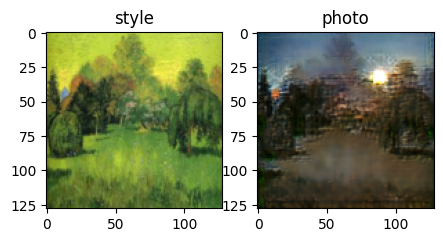

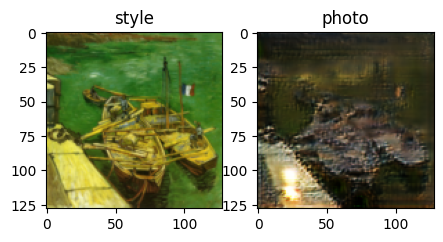

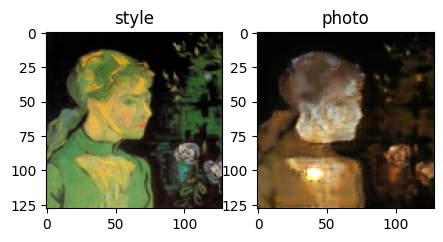

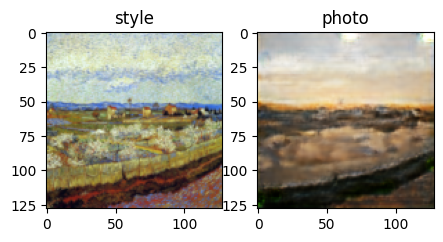

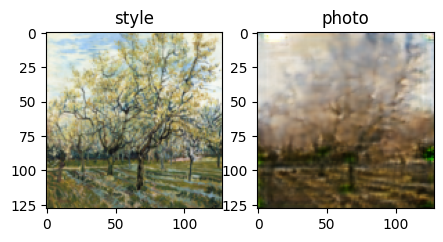

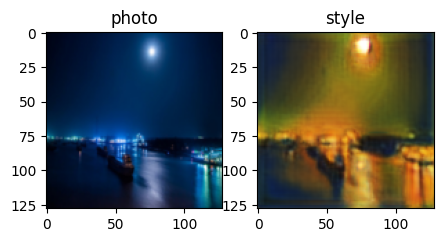

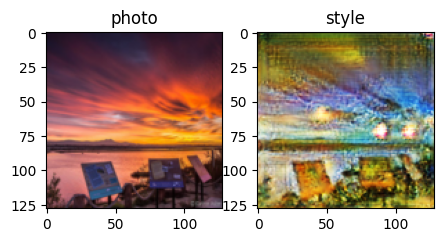

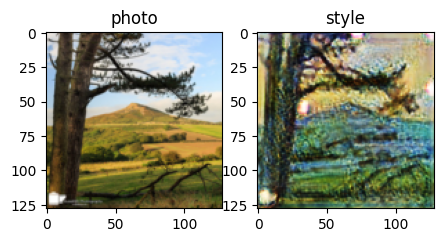

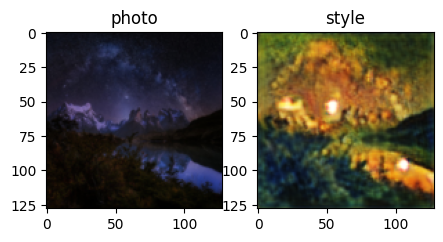

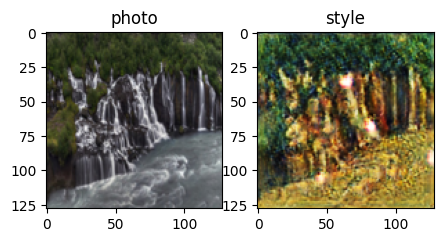

In [64]:
# test results

Testset_X = MyDataset(path= f'./data/{dataset}/testA/', num=400, transform=transform)
Testset_Y = MyDataset(path= f'./data/{dataset}/testB/', num=751, transform=transform)

test_X = DataLoader(Testset_X, batch_size=1, shuffle=True)
test_Y = DataLoader(Testset_Y, batch_size=1, shuffle=True) 
test_X = [x for x in test_X]
test_Y = [y for y in test_Y]

# test Gxy
for x in random.sample(test_X, 5):
    real_x = x.type(dtype)
    fake_y = Gxy(real_x)

    plt.figure(figsize=(5, 10))

    plt.subplot(1,2,1)
    plt.title('style')
    plt.imshow(real_x[0].detach().cpu().permute(1,2,0))

    plt.subplot(1,2,2)
    plt.title('photo')
    plt.imshow(fake_y[0].detach().cpu().permute(1,2,0))
    plt.show()

# test Gyx
for y in random.sample(test_Y, 5):
    real_y = y.type(dtype)
    fake_x = Gyx(real_y)

    plt.figure(figsize=(5, 10))

    plt.subplot(1,2,1)
    plt.title('photo')
    plt.imshow(real_y[0].detach().cpu().permute(1,2,0))

    plt.subplot(1,2,2)
    plt.title('style')
    plt.imshow(fake_x[0].detach().cpu().permute(1,2,0))
    plt.show()

In [ ]:
# save the model
torch.save(Gxy.state_dict(), 'Gxy.pth')
torch.save(Gyx.state_dict(), 'Gyx.pth')
torch.save(Dx.state_dict(), 'Dx.pth')
torch.save(Dy.state_dict(), 'Dy.pth')

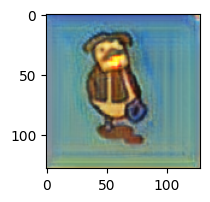

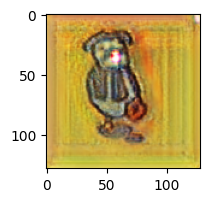

In [79]:
# for fun
from PIL import Image

image = transform(Image.open('5.png').convert('RGB')).type(dtype)
image = image.unsqueeze(0)
for i in range(1):
    image = Gyx(image)
    plt.figure(figsize=(2, 2))
    plt.imshow(image[0].detach().cpu().permute(1,2,0))
    plt.show()
    image = Gyx(image)
    plt.figure(figsize=(2, 2))
    plt.imshow(image[0].detach().cpu().permute(1,2,0))
    plt.show()